In [1]:
import sys
sys.path.append('..')

import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from cleansing.data_cleansing import preprocess_data
import numpy as np

# 데이터 전처리 함수 호출
X_train, X_test, y_train, y_test = preprocess_data()

# LightGBM 모델 설정
params_lgb = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': 6,
    'min_child_weight': 0.1,
    'verbosity': -1
}

# CatBoost 모델 설정
params_catboost = {
    'iterations': 1000,
    'learning_rate': 0.05,
    'depth': 6,
    'loss_function': 'RMSE',
    'verbose': False
}

# Random Forest 모델 설정
params_rf = {
    'n_estimators': 100,
    'max_depth': 6,
    'min_samples_split': 10,
    'min_samples_leaf': 5,
    'random_state': 42
}

# XGBoost 모델 설정
params_xgb = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.05,
    'max_depth': 6,
    'min_child_weight': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'verbosity': 0
}

# GradientBoosting 모델 설정
params_gb = {
    'n_estimators': 100,
    'learning_rate': 0.1,
    'max_depth': 6,
    'min_samples_split': 10,
    'min_samples_leaf': 5,
    'random_state': 42
}

# KFold 교차 검증
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 모델 리스트 초기화
models = []

# 각 모델에 대한 KFold 교차 검증 수행
for train_index, valid_index in kf.split(X_train):
    
    # LightGBM 모델 학습
    lgb_train = lgb.Dataset(X_train.iloc[train_index], label=y_train.iloc[train_index])
    lgb_valid = lgb.Dataset(X_train.iloc[valid_index], label=y_train.iloc[valid_index])
    bst_lgb = lgb.train(params_lgb, lgb_train, valid_sets=[lgb_train, lgb_valid], early_stopping_rounds=10, verbose_eval=0)
    
    # CatBoost 모델 학습
    cb_train = CatBoostRegressor(**params_catboost)
    cb_train.fit(X_train.iloc[train_index], y_train.iloc[train_index])
    
    # Random Forest 모델 학습
    rf_train = RandomForestRegressor(**params_rf)
    rf_train.fit(X_train.iloc[train_index], y_train.iloc[train_index])
    
    # XGBoost 모델 학습
    xgb_train = XGBRegressor(**params_xgb)
    xgb_train.fit(X_train.iloc[train_index], y_train.iloc[train_index])

    # Gradient Boosting 모델 학습
    gb_train = GradientBoostingRegressor(**params_gb)
    gb_train.fit(X_train.iloc[train_index], y_train.iloc[train_index])

# 모델 리스트에 학습된 모델 추가
models.append((bst_lgb, cb_train, rf_train, xgb_train, gb_train))

# 각 모델의 예측 결과를 더해줌

predictions = np.zeros(len(X_test))

for model in models:
    predictions += model[0].predict(X_test)
    predictions += model[1].predict(X_test)
    predictions += model[2].predict(X_test)
    predictions += model[3].predict(X_test)
    predictions += model[4].predict(X_test)

# 예측 결과의 평균을 구함

predictions /= len(models) * 5

# 예측 결과 출력

print('MSE:', mean_squared_error(y_test, predictions))

/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' 

MSE: 0.015758073354521777


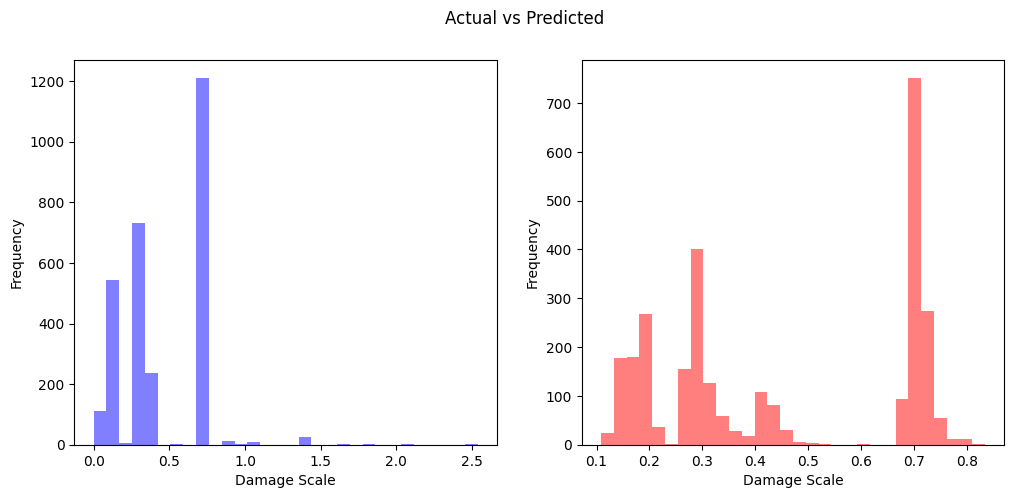

In [2]:
# 모델 예측값과 y 레이블의 정답값 분포 시각화
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 예측값과 실제값의 분포 시각화
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Actual vs Predicted')

# y_test 히스토그램
axs[0].hist(y_test, bins=30, alpha=0.5, color='blue', label='Actual')
axs[0].set_xlabel('Damage Scale')
axs[0].set_ylabel('Frequency')

# y_pred_lgb 히스토그램
axs[1].hist(predictions, bins=30, alpha=0.5, color='red', label='Predicted')
axs[1].set_xlabel('Damage Scale')
axs[1].set_ylabel('Frequency')

plt.show()



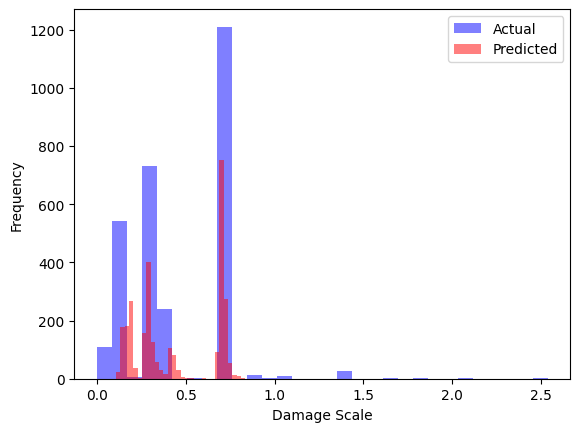

In [3]:
fig, ax = plt.subplots()
ax.hist(y_test, bins=30, alpha=0.5, color='blue', label='Actual')
ax.hist(predictions, bins=30, alpha=0.5, color='red', label='Predicted')
ax.set_xlabel('Damage Scale')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()

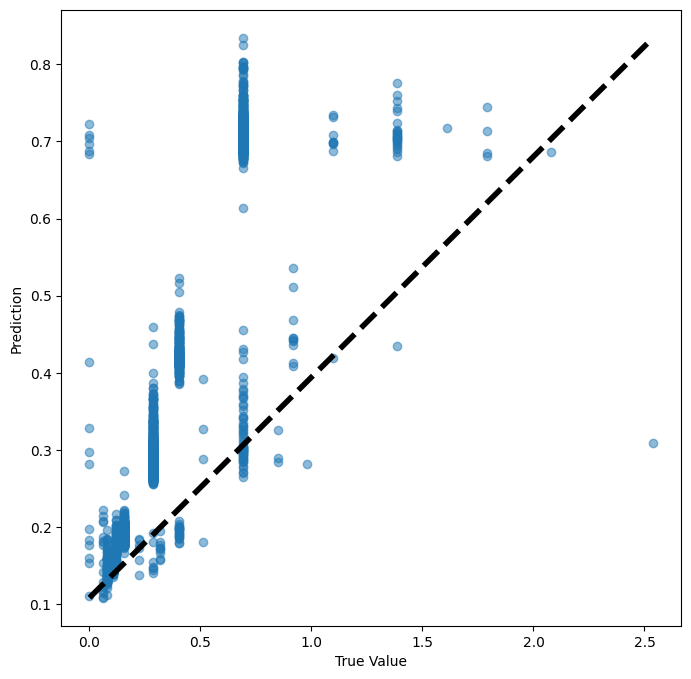

In [4]:
import matplotlib.pyplot as plt

# 예측값과 실제값 비교
plt.figure(figsize=(8, 8))
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [predictions.min(), predictions.max()], 'k--', lw=4)
plt.xlabel('True Value')
plt.ylabel('Prediction')
plt.show()


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# y_test: 실제 값, prediction: 예측 값
accuracy = np.sum(np.abs(y_test['피해규모'].values - predictions) <= 0.1) / len(y_test)

print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 59.52%


In [11]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

## 주의!! 컴퓨터에 자신 없으면 돌리지 말 것. 돌렸다가 컴퓨터 터질뻔함.

param_dist_lgb = {
    'num_leaves': sp_randint(10, 500),
    'learning_rate': sp_uniform(loc=0.01, scale=0.1),
    'feature_fraction': sp_uniform(loc=0.5, scale=0.5),
    'bagging_fraction': sp_uniform(loc=0.5, scale=0.5),
    'bagging_freq': sp_randint(1, 10),
    'max_depth': sp_randint(3, 15),
    'min_child_weight': sp_uniform(loc=0, scale=1),
    'metric': ['mae', 'rmse']
}

param_dist_cat = {
    'learning_rate': sp_uniform(loc=0.01, scale=0.1),
    'depth': sp_randint(3, 10),
    'iterations': sp_randint(50, 200),
    'bagging_temperature': sp_uniform(loc=0.0, scale=1.0),
    'l2_leaf_reg': sp_uniform(loc=0.0, scale=1.0),
}

param_dist_rf = {
    'n_estimators': sp_randint(50, 200),
    'max_depth': sp_randint(3, 15),
    'min_samples_split': sp_randint(2, 20),
    'min_samples_leaf': sp_randint(1, 10)
}

param_dist_xgb = {
    'learning_rate': sp_uniform(loc=0.01, scale=0.1),
    'max_depth': sp_randint(3, 15),
    'min_child_weight': sp_uniform(loc=0, scale=1),
    'subsample': sp_uniform(loc=0.5, scale=0.5),
    'colsample_bytree': sp_uniform(loc=0.5, scale=0.5),
    'gamma': sp_uniform(loc=0.0, scale=1.0),
}

param_dist_gb = {
    'n_estimators': sp_randint(50, 200),
    'learning_rate': sp_uniform(loc=0.01, scale=0.1),
    'max_depth': sp_randint(3, 15),
    'min_samples_split': sp_randint(2, 20),
    'min_samples_leaf': sp_randint(1, 10)
}

rs_lgb = RandomizedSearchCV(lgb.LGBMRegressor(), param_distributions=param_dist_lgb, n_iter=50, cv=5, n_jobs=-1, verbose=2)
rs_lgb.fit(X_train, y_train)
best_params_lgb = rs_lgb.best_params_

rs_cat = RandomizedSearchCV(CatBoostRegressor(silent=True), param_distributions=param_dist_cat, n_iter=50, cv=5, n_jobs=-1, verbose=2)
rs_cat.fit(X_train, y_train)
best_params_cat = rs_cat.best_params_

rs_rf = RandomizedSearchCV(RandomForestRegressor(), param_distributions=param_dist_rf, n_iter=50, cv=5, n_jobs=-1, verbose=2)
rs_rf.fit(X_train, y_train)
best_params_rf = rs_rf.best_params_

rs_xgb = RandomizedSearchCV(XGBRegressor(), param_distributions=param_dist_xgb, n_iter=50, cv=5, n_jobs=-1, verbose=2)
rs_xgb.fit(X_train, y_train)
best_params_xgb = rs_xgb.best_params_

rs_gb = RandomizedSearchCV(GradientBoostingRegressor(), param_distributions=param_dist_gb, n_iter=50, cv=5, n_jobs=-1, verbose=2)
rs_gb.fit(X_train, y_train)
best_params_gb = rs_gb.best_params_

# KFold 교차 검증
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 모델 리스트 초기화
models = []

# 각 모델에 대한 KFold 교차 검증 수행
for train_index, valid_index in kf.split(X_train):
    
    # LightGBM 모델 학습
    lgb_train = lgb.Dataset(X_train.iloc[train_index], label=y_train.iloc[train_index])
    lgb_valid = lgb.Dataset(X_train.iloc[valid_index], label=y_train.iloc[valid_index])
    bst_lgb = lgb.train(best_params_lgb, lgb_train, valid_sets=[lgb_train, lgb_valid], early_stopping_rounds=10, verbose_eval=0)
    
    # CatBoost 모델 학습
    cb_train = CatBoostRegressor(**best_params_cat)
    cb_train.fit(X_train.iloc[train_index], y_train.iloc[train_index])
    
    # Random Forest 모델 학습
    rf_train = RandomForestRegressor(**best_params_rf)
    rf_train.fit(X_train.iloc[train_index], y_train.iloc[train_index])
    
    # XGBoost 모델 학습
    xgb_train = XGBRegressor(**best_params_xgb)
    xgb_train.fit(X_train.iloc[train_index], y_train.iloc[train_index])

    # Gradient Boosting 모델 학습
    gb_train = GradientBoostingRegressor(**best_params_gb)
    gb_train.fit(X_train.iloc[train_index], y_train.iloc[train_index])

# 모델 리스트에 학습된 모델 추가
models.append((bst_lgb, cb_train, rf_train, xgb_train, gb_train))

# 각 모델의 예측 결과를 더해줌

predictions = np.zeros(len(X_test))

for model in models:
    predictions += model[0].predict(X_test)
    predictions += model[1].predict(X_test)
    predictions += model[2].predict(X_test)
    predictions += model[3].predict(X_test)
    predictions += model[4].predict(X_test)

# 예측 결과의 평균을 구함

predictions /= len(models) * 5

# 예측 결과 출력

print('MSE:', mean_squared_error(y_test, predictions))


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Warning] bagging_fraction is set=0.5152191633168834, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5152191633168834
[LightGBM] [Warning] feature_fraction is set=0.5346666764853412, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5346666764853412
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6974169322308819, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6974169322308819
[LightGBM] [Warning] feature_fraction is set=0.7346363453927411, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7346363453927411
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.5152191633168834, subsample=1.0 will be ignored. Current value: bagging_f

/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/ber

[CV] END max_depth=8, min_samples_leaf=6, min_samples_split=14, n_estimators=139; total time=   1.9s
[CV] END max_depth=8, min_samples_leaf=6, min_samples_split=14, n_estimators=139; total time=   1.9s
[CV] END max_depth=8, min_samples_leaf=6, min_samples_split=14, n_estimators=139; total time=   2.0s
[CV] END max_depth=8, min_samples_leaf=6, min_samples_split=14, n_estimators=139; total time=   2.0s
[CV] END max_depth=8, min_samples_leaf=6, min_samples_split=14, n_estimators=139; total time=   2.0s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/ber

[CV] END max_depth=10, min_samples_leaf=9, min_samples_split=16, n_estimators=146; total time=   2.4s
[CV] END max_depth=10, min_samples_leaf=9, min_samples_split=16, n_estimators=146; total time=   2.4s
[CV] END max_depth=10, min_samples_leaf=9, min_samples_split=16, n_estimators=146; total time=   2.4s
[CV] END max_depth=10, min_samples_leaf=9, min_samples_split=16, n_estimators=146; total time=   2.4s
[CV] END max_depth=10, min_samples_leaf=9, min_samples_split=16, n_estimators=146; total time=   2.5s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/ber

[CV] END max_depth=12, min_samples_leaf=3, min_samples_split=12, n_estimators=131; total time=   2.6s
[CV] END max_depth=12, min_samples_leaf=3, min_samples_split=12, n_estimators=131; total time=   2.6s
[CV] END max_depth=12, min_samples_leaf=3, min_samples_split=12, n_estimators=131; total time=   2.6s
[CV] END max_depth=12, min_samples_leaf=3, min_samples_split=12, n_estimators=131; total time=   2.6s
[CV] END max_depth=12, min_samples_leaf=3, min_samples_split=12, n_estimators=131; total time=   2.6s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/ber

[CV] END max_depth=13, min_samples_leaf=9, min_samples_split=19, n_estimators=190; total time=   3.8s
[CV] END max_depth=13, min_samples_leaf=9, min_samples_split=19, n_estimators=190; total time=   3.8s
[CV] END max_depth=13, min_samples_leaf=9, min_samples_split=19, n_estimators=190; total time=   3.8s
[CV] END max_depth=13, min_samples_leaf=9, min_samples_split=19, n_estimators=190; total time=   3.9s
[CV] END max_depth=13, min_samples_leaf=9, min_samples_split=19, n_estimators=190; total time=   3.8s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/ber

[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=3, n_estimators=92; total time=   1.6s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=3, n_estimators=92; total time=   1.6s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=3, n_estimators=92; total time=   1.5s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=3, n_estimators=92; total time=   1.6s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=3, n_estimators=92; total time=   1.6s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/ber

[CV] END max_depth=8, min_samples_leaf=4, min_samples_split=14, n_estimators=115; total time=   1.6s
[CV] END max_depth=8, min_samples_leaf=4, min_samples_split=14, n_estimators=115; total time=   1.7s
[CV] END max_depth=8, min_samples_leaf=4, min_samples_split=14, n_estimators=115; total time=   1.6s
[CV] END max_depth=8, min_samples_leaf=4, min_samples_split=14, n_estimators=115; total time=   1.6s
[CV] END max_depth=8, min_samples_leaf=4, min_samples_split=14, n_estimators=115; total time=   1.6s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/ber

[CV] END max_depth=3, min_samples_leaf=7, min_samples_split=2, n_estimators=105; total time=   0.6s
[CV] END max_depth=3, min_samples_leaf=7, min_samples_split=2, n_estimators=105; total time=   0.7s
[CV] END max_depth=3, min_samples_leaf=7, min_samples_split=2, n_estimators=105; total time=   0.7s
[CV] END max_depth=3, min_samples_leaf=7, min_samples_split=2, n_estimators=105; total time=   0.7s
[CV] END max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=164; total time=   1.5s
[CV] END max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=164; total time=   1.5s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/ber

[CV] END max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=164; total time=   1.6s
[CV] END max_depth=3, min_samples_leaf=7, min_samples_split=2, n_estimators=105; total time=   0.7s
[CV] END max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=164; total time=   1.6s
[CV] END max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=164; total time=   1.6s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/ber

[CV] END max_depth=11, min_samples_leaf=1, min_samples_split=8, n_estimators=183; total time=   3.4s
[CV] END max_depth=11, min_samples_leaf=1, min_samples_split=8, n_estimators=183; total time=   3.4s
[CV] END max_depth=11, min_samples_leaf=1, min_samples_split=8, n_estimators=183; total time=   3.3s
[CV] END max_depth=11, min_samples_leaf=1, min_samples_split=8, n_estimators=183; total time=   3.4s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/ber

[CV] END max_depth=11, min_samples_leaf=1, min_samples_split=8, n_estimators=183; total time=   3.4s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=14, min_samples_leaf=3, min_samples_split=19, n_estimators=189; total time=   4.0s
[CV] END max_depth=14, min_samples_leaf=3, min_samples_split=19, n_estimators=189; total time=   4.1s
[CV] END max_depth=14, min_samples_leaf=3, min_samples_split=19, n_estimators=189; total time=   4.1s
[CV] END max_depth=14, min_samples_leaf=3, min_samples_split=19, n_estimators=189; total time=   4.1s
[CV] END max_depth=14, min_samples_leaf=3, min_samples_split=19, n_estimators=189; total time=   4.1s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/ber

[CV] END max_depth=7, min_samples_leaf=1, min_samples_split=6, n_estimators=152; total time=   1.9s
[CV] END max_depth=7, min_samples_leaf=1, min_samples_split=6, n_estimators=152; total time=   1.9s
[CV] END max_depth=7, min_samples_leaf=1, min_samples_split=6, n_estimators=152; total time=   1.9s
[CV] END max_depth=7, min_samples_leaf=1, min_samples_split=6, n_estimators=152; total time=   1.9s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/ber

[CV] END max_depth=7, min_samples_leaf=1, min_samples_split=6, n_estimators=152; total time=   2.0s
[CV] END max_depth=13, min_samples_leaf=1, min_samples_split=19, n_estimators=147; total time=   3.1s
[CV] END max_depth=13, min_samples_leaf=1, min_samples_split=19, n_estimators=147; total time=   3.1s
[CV] END max_depth=13, min_samples_leaf=1, min_samples_split=19, n_estimators=147; total time=   3.0s
[CV] END max_depth=13, min_samples_leaf=1, min_samples_split=19, n_estimators=147; total time=   3.1s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/ber

[CV] END max_depth=13, min_samples_leaf=1, min_samples_split=19, n_estimators=147; total time=   3.1s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=7, min_samples_leaf=5, min_samples_split=11, n_estimators=171; total time=   2.1s
[CV] END max_depth=7, min_samples_leaf=5, min_samples_split=11, n_estimators=171; total time=   2.1s
[CV] END max_depth=7, min_samples_leaf=5, min_samples_split=11, n_estimators=171; total time=   2.1s
[CV] END max_depth=7, min_samples_leaf=5, min_samples_split=11, n_estimators=171; total time=   2.1s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/ber

[CV] END max_depth=7, min_samples_leaf=5, min_samples_split=11, n_estimators=171; total time=   2.1s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=9, n_estimators=189; total time=   1.1s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=9, n_estimators=189; total time=   1.1s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=9, n_estimators=189; total time=   1.1s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=9, n_estimators=189; total time=   1.1s
[CV] END max_depth=13, min_samples_leaf=4, min_samples_split=5, n_estimators=146; total time=   3.0s
[CV] END max_depth=13, min_samples_leaf=4, min_samples_split=5, n_estimators=146; total time=   3.0s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/ber

[CV] END max_depth=13, min_samples_leaf=4, min_samples_split=5, n_estimators=146; total time=   3.0s
[CV] END max_depth=13, min_samples_leaf=4, min_samples_split=5, n_estimators=146; total time=   3.1s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=9, n_estimators=189; total time=   1.1s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=13, min_samples_leaf=4, min_samples_split=5, n_estimators=146; total time=   3.0s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=9, min_samples_leaf=9, min_samples_split=17, n_estimators=144; total time=   2.2s
[CV] END max_depth=9, min_samples_leaf=9, min_samples_split=17, n_estimators=144; total time=   2.2s
[CV] END max_depth=9, min_samples_leaf=9, min_samples_split=17, n_estimators=144; total time=   2.2s
[CV] END max_depth=9, min_samples_leaf=9, min_samples_split=17, n_estimators=144; total time=   2.3s
[CV] END max_depth=9, min_samples_leaf=9, min_samples_split=17, n_estimators=144; total time=   2.2s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/ber

[CV] END max_depth=14, min_samples_leaf=1, min_samples_split=5, n_estimators=120; total time=   2.6s
[CV] END max_depth=14, min_samples_leaf=1, min_samples_split=5, n_estimators=120; total time=   2.8s
[CV] END max_depth=14, min_samples_leaf=1, min_samples_split=5, n_estimators=120; total time=   2.7s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=14, min_samples_leaf=1, min_samples_split=5, n_estimators=120; total time=   2.7s
[CV] END max_depth=14, min_samples_leaf=1, min_samples_split=5, n_estimators=120; total time=   2.7s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=8, min_samples_split=10, n_estimators=164; total time=   1.3s
[CV] END max_depth=5, min_samples_leaf=4, min_samples_split=8, n_estimators=73; total time=   0.7s
[CV] END max_depth=4, min_samples_leaf=8, min_samples_split=10, n_estimators=164; total time=   1.3s
[CV] END max_depth=4, min_samples_leaf=8, min_samples_split=10, n_estimators=164; total time=   1.3s
[CV] END max_depth=4, min_samples_leaf=8, min_samples_split=10, n_estimators=164; total time=   1.3s
[CV] END max_depth=5, min_samples_leaf=4, min_samples_split=8, n_estimators=73; total time=   0.7s
[CV] END max_depth=4, min_samples_leaf=8, min_samples_split=10, n_estimators=164; total time=   1.2s
[CV] END max_depth=5, min_samples_leaf=4, min_samples_split=8, n_estimators=73; total time=   0.7s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/ber

[CV] END max_depth=5, min_samples_leaf=4, min_samples_split=8, n_estimators=73; total time=   0.7s
[CV] END max_depth=5, min_samples_leaf=4, min_samples_split=8, n_estimators=73; total time=   0.7s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=9, min_samples_leaf=2, min_samples_split=19, n_estimators=190; total time=   2.9s
[CV] END max_depth=9, min_samples_leaf=2, min_samples_split=19, n_estimators=190; total time=   3.0s
[CV] END max_depth=9, min_samples_leaf=2, min_samples_split=19, n_estimators=190; total time=   3.0s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=9, min_samples_leaf=2, min_samples_split=19, n_estimators=190; total time=   3.0s
[CV] END max_depth=13, min_samples_leaf=5, min_samples_split=16, n_estimators=164; total time=   3.3s
[CV] END max_depth=9, min_samples_leaf=2, min_samples_split=19, n_estimators=190; total time=   3.0s
[CV] END max_depth=13, min_samples_leaf=5, min_samples_split=16, n_estimators=164; total time=   3.3s
[CV] END max_depth=13, min_samples_leaf=5, min_samples_split=16, n_estimators=164; total time=   3.3s
[CV] END max_depth=13, min_samples_leaf=5, min_samples_split=16, n_estimators=164; total time=   3.4s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/ber

[CV] END max_depth=13, min_samples_leaf=5, min_samples_split=16, n_estimators=164; total time=   3.4s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=7, min_samples_leaf=4, min_samples_split=6, n_estimators=92; total time=   1.2s
[CV] END max_depth=7, min_samples_leaf=4, min_samples_split=6, n_estimators=92; total time=   1.3s
[CV] END max_depth=7, min_samples_leaf=4, min_samples_split=6, n_estimators=92; total time=   1.2s
[CV] END max_depth=7, min_samples_leaf=4, min_samples_split=6, n_estimators=92; total time=   1.2s
[CV] END max_depth=7, min_samples_leaf=4, min_samples_split=6, n_estimators=92; total time=   1.2s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/ber

[CV] END max_depth=6, min_samples_leaf=5, min_samples_split=7, n_estimators=195; total time=   2.3s
[CV] END max_depth=6, min_samples_leaf=5, min_samples_split=7, n_estimators=195; total time=   2.2s
[CV] END max_depth=6, min_samples_leaf=5, min_samples_split=7, n_estimators=195; total time=   2.3s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=5, min_samples_split=7, n_estimators=195; total time=   2.2s
[CV] END max_depth=6, min_samples_leaf=5, min_samples_split=7, n_estimators=195; total time=   2.3s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=4, n_estimators=169; total time=   2.4s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=4, n_estimators=169; total time=   2.4s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=4, n_estimators=169; total time=   2.4s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=4, n_estimators=169; total time=   2.4s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=4, n_estimators=169; total time=   2.4s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=13, min_samples_leaf=6, min_samples_split=14, n_estimators=185; total time=   3.8s
[CV] END max_depth=13, min_samples_leaf=6, min_samples_split=14, n_estimators=185; total time=   3.8s
[CV] END max_depth=13, min_samples_leaf=6, min_samples_split=14, n_estimators=185; total time=   3.8s
[CV] END max_depth=13, min_samples_leaf=6, min_samples_split=14, n_estimators=185; total time=   3.8s
[CV] END max_depth=13, min_samples_leaf=6, min_samples_split=14, n_estimators=185; total time=   3.9s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/ber

[CV] END max_depth=7, min_samples_leaf=5, min_samples_split=4, n_estimators=105; total time=   1.3s
[CV] END max_depth=7, min_samples_leaf=5, min_samples_split=4, n_estimators=105; total time=   1.3s
[CV] END max_depth=7, min_samples_leaf=5, min_samples_split=4, n_estimators=105; total time=   1.3s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=7, min_samples_leaf=5, min_samples_split=4, n_estimators=105; total time=   1.4s
[CV] END max_depth=7, min_samples_leaf=5, min_samples_split=4, n_estimators=105; total time=   1.4s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=6, n_estimators=163; total time=   1.6s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=6, n_estimators=163; total time=   1.6s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=6, n_estimators=163; total time=   1.5s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=6, n_estimators=163; total time=   1.5s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=6, n_estimators=163; total time=   1.6s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/ber

[CV] END max_depth=7, min_samples_leaf=1, min_samples_split=9, n_estimators=171; total time=   2.0s
[CV] END max_depth=7, min_samples_leaf=1, min_samples_split=9, n_estimators=171; total time=   2.1s
[CV] END max_depth=7, min_samples_leaf=1, min_samples_split=9, n_estimators=171; total time=   2.1s
[CV] END max_depth=7, min_samples_leaf=1, min_samples_split=9, n_estimators=171; total time=   2.1s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/ber

[CV] END max_depth=7, min_samples_leaf=1, min_samples_split=9, n_estimators=171; total time=   2.1s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=13, n_estimators=199; total time=   3.3s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=13, n_estimators=199; total time=   3.2s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=13, n_estimators=199; total time=   3.3s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=13, n_estimators=199; total time=   3.2s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=13, n_estimators=199; total time=   3.2s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=7, min_samples_split=18, n_estimators=78; total time=   0.8s
[CV] END max_depth=6, min_samples_leaf=7, min_samples_split=18, n_estimators=78; total time=   0.8s
[CV] END max_depth=6, min_samples_leaf=7, min_samples_split=18, n_estimators=78; total time=   0.8s
[CV] END max_depth=6, min_samples_leaf=7, min_samples_split=18, n_estimators=78; total time=   0.8s
[CV] END max_depth=6, min_samples_leaf=7, min_samples_split=18, n_estimators=78; total time=   0.8s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/ber

[CV] END max_depth=4, min_samples_leaf=3, min_samples_split=17, n_estimators=137; total time=   1.0s
[CV] END max_depth=4, min_samples_leaf=3, min_samples_split=17, n_estimators=137; total time=   1.0s
[CV] END max_depth=4, min_samples_leaf=3, min_samples_split=17, n_estimators=137; total time=   1.0s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=3, min_samples_split=17, n_estimators=137; total time=   1.1s
[CV] END max_depth=4, min_samples_leaf=3, min_samples_split=17, n_estimators=137; total time=   1.1s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=9, min_samples_leaf=6, min_samples_split=11, n_estimators=199; total time=   3.0s
[CV] END max_depth=9, min_samples_leaf=6, min_samples_split=11, n_estimators=199; total time=   3.0s
[CV] END max_depth=8, min_samples_leaf=3, min_samples_split=18, n_estimators=188; total time=   2.5s
[CV] END max_depth=9, min_samples_leaf=6, min_samples_split=11, n_estimators=199; total time=   3.0s
[CV] END max_depth=8, min_samples_leaf=3, min_samples_split=18, n_estimators=188; total time=   2.6s
[CV] END max_depth=9, min_samples_leaf=6, min_samples_split=11, n_estimators=199; total time=   3.0s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/ber

[CV] END max_depth=9, min_samples_leaf=6, min_samples_split=11, n_estimators=199; total time=   3.1s
[CV] END max_depth=8, min_samples_leaf=3, min_samples_split=18, n_estimators=188; total time=   2.6s
[CV] END max_depth=8, min_samples_leaf=3, min_samples_split=18, n_estimators=188; total time=   2.5s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=3, min_samples_split=18, n_estimators=188; total time=   2.6s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=3, min_samples_leaf=2, min_samples_split=11, n_estimators=152; total time=   0.9s
[CV] END max_depth=3, min_samples_leaf=2, min_samples_split=11, n_estimators=152; total time=   0.8s
[CV] END max_depth=3, min_samples_leaf=2, min_samples_split=11, n_estimators=152; total time=   0.9s
[CV] END max_depth=3, min_samples_leaf=2, min_samples_split=11, n_estimators=152; total time=   0.8s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/ber

[CV] END max_depth=3, min_samples_leaf=2, min_samples_split=11, n_estimators=152; total time=   0.9s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=14, min_samples_leaf=6, min_samples_split=13, n_estimators=82; total time=   1.7s
[CV] END max_depth=14, min_samples_leaf=6, min_samples_split=13, n_estimators=82; total time=   1.7s
[CV] END max_depth=14, min_samples_leaf=6, min_samples_split=13, n_estimators=82; total time=   1.6s
[CV] END max_depth=14, min_samples_leaf=6, min_samples_split=13, n_estimators=82; total time=   1.8s
[CV] END max_depth=14, min_samples_leaf=6, min_samples_split=13, n_estimators=82; total time=   1.8s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/ber

[CV] END max_depth=6, min_samples_leaf=7, min_samples_split=15, n_estimators=146; total time=   1.5s
[CV] END max_depth=6, min_samples_leaf=7, min_samples_split=15, n_estimators=146; total time=   1.5s
[CV] END max_depth=6, min_samples_leaf=7, min_samples_split=15, n_estimators=146; total time=   1.5s
[CV] END max_depth=6, min_samples_leaf=7, min_samples_split=15, n_estimators=146; total time=   1.5s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/ber

[CV] END max_depth=6, min_samples_leaf=7, min_samples_split=15, n_estimators=146; total time=   1.6s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=7, min_samples_leaf=9, min_samples_split=11, n_estimators=135; total time=   1.6s
[CV] END max_depth=7, min_samples_leaf=9, min_samples_split=11, n_estimators=135; total time=   1.6s
[CV] END max_depth=7, min_samples_leaf=9, min_samples_split=11, n_estimators=135; total time=   1.6s
[CV] END max_depth=7, min_samples_leaf=9, min_samples_split=11, n_estimators=135; total time=   1.6s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/ber

[CV] END max_depth=7, min_samples_leaf=9, min_samples_split=11, n_estimators=135; total time=   1.6s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=14, min_samples_leaf=4, min_samples_split=5, n_estimators=153; total time=   3.2s
[CV] END max_depth=14, min_samples_leaf=4, min_samples_split=5, n_estimators=153; total time=   3.3s
[CV] END max_depth=14, min_samples_leaf=4, min_samples_split=5, n_estimators=153; total time=   3.2s
[CV] END max_depth=14, min_samples_leaf=4, min_samples_split=5, n_estimators=153; total time=   3.3s
[CV] END max_depth=14, min_samples_leaf=4, min_samples_split=5, n_estimators=153; total time=   3.2s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/ber

[CV] END max_depth=5, min_samples_leaf=8, min_samples_split=2, n_estimators=108; total time=   1.0s
[CV] END max_depth=5, min_samples_leaf=8, min_samples_split=2, n_estimators=108; total time=   1.0s
[CV] END max_depth=5, min_samples_leaf=8, min_samples_split=2, n_estimators=108; total time=   1.0s
[CV] END max_depth=5, min_samples_leaf=8, min_samples_split=2, n_estimators=108; total time=   1.0s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/ber

[CV] END max_depth=5, min_samples_leaf=8, min_samples_split=2, n_estimators=108; total time=   1.0s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=7, min_samples_leaf=2, min_samples_split=9, n_estimators=83; total time=   1.0s
[CV] END max_depth=7, min_samples_leaf=2, min_samples_split=9, n_estimators=83; total time=   1.0s
[CV] END max_depth=7, min_samples_leaf=2, min_samples_split=9, n_estimators=83; total time=   1.0s
[CV] END max_depth=7, min_samples_leaf=2, min_samples_split=9, n_estimators=83; total time=   1.1s
[CV] END max_depth=7, min_samples_leaf=2, min_samples_split=9, n_estimators=83; total time=   1.0s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/ber

[CV] END max_depth=7, min_samples_leaf=4, min_samples_split=12, n_estimators=138; total time=   1.7s
[CV] END max_depth=7, min_samples_leaf=4, min_samples_split=12, n_estimators=138; total time=   1.8s
[CV] END max_depth=7, min_samples_leaf=4, min_samples_split=12, n_estimators=138; total time=   1.7s
[CV] END max_depth=7, min_samples_leaf=4, min_samples_split=12, n_estimators=138; total time=   1.8s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/ber

[CV] END max_depth=7, min_samples_leaf=4, min_samples_split=12, n_estimators=138; total time=   1.8s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=13, min_samples_leaf=9, min_samples_split=17, n_estimators=113; total time=   2.3s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=3, n_estimators=136; total time=   1.3s
[CV] END max_depth=13, min_samples_leaf=9, min_samples_split=17, n_estimators=113; total time=   2.3s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=3, n_estimators=136; total time=   1.4s
[CV] END max_depth=13, min_samples_leaf=9, min_samples_split=17, n_estimators=113; total time=   2.3s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=3, n_estimators=136; total time=   1.3s
[CV] END max_depth=13, min_samples_leaf=9, min_samples_split=17, n_estimators=113; total time=   2.3s
[CV] END max_depth=13, min_samples_leaf=9, min_samples_split=17, n_estimators=113; total time=   2.3s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=3, n_estimators=136; total time=   1.3s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/ber

[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=3, n_estimators=136; total time=   1.3s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=10, min_samples_leaf=6, min_samples_split=11, n_estimators=57; total time=   0.9s
[CV] END max_depth=10, min_samples_leaf=6, min_samples_split=11, n_estimators=57; total time=   0.9s
[CV] END max_depth=10, min_samples_leaf=6, min_samples_split=11, n_estimators=57; total time=   0.9s
[CV] END max_depth=10, min_samples_leaf=6, min_samples_split=11, n_estimators=57; total time=   1.0s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/ber

[CV] END max_depth=10, min_samples_leaf=6, min_samples_split=11, n_estimators=57; total time=   0.9s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=7, min_samples_leaf=1, min_samples_split=8, n_estimators=178; total time=   2.2s
[CV] END max_depth=7, min_samples_leaf=1, min_samples_split=8, n_estimators=178; total time=   2.2s
[CV] END max_depth=7, min_samples_leaf=1, min_samples_split=8, n_estimators=178; total time=   2.2s
[CV] END max_depth=7, min_samples_leaf=1, min_samples_split=8, n_estimators=178; total time=   2.2s
[CV] END max_depth=7, min_samples_leaf=1, min_samples_split=8, n_estimators=178; total time=   2.2s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/ber

[CV] END max_depth=6, min_samples_leaf=2, min_samples_split=3, n_estimators=145; total time=   1.5s
[CV] END max_depth=6, min_samples_leaf=2, min_samples_split=3, n_estimators=145; total time=   1.6s
[CV] END max_depth=6, min_samples_leaf=2, min_samples_split=3, n_estimators=145; total time=   1.5s
[CV] END max_depth=6, min_samples_leaf=2, min_samples_split=3, n_estimators=145; total time=   1.5s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/ber

[CV] END max_depth=6, min_samples_leaf=2, min_samples_split=3, n_estimators=145; total time=   1.5s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=7, min_samples_leaf=3, min_samples_split=16, n_estimators=103; total time=   1.3s
[CV] END max_depth=7, min_samples_leaf=3, min_samples_split=16, n_estimators=103; total time=   1.3s
[CV] END max_depth=7, min_samples_leaf=3, min_samples_split=16, n_estimators=103; total time=   1.3s
[CV] END max_depth=7, min_samples_leaf=3, min_samples_split=16, n_estimators=103; total time=   1.3s
[CV] END max_depth=7, min_samples_leaf=3, min_samples_split=16, n_estimators=103; total time=   1.3s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/ber

[CV] END max_depth=7, min_samples_leaf=5, min_samples_split=7, n_estimators=123; total time=   1.5s
[CV] END max_depth=7, min_samples_leaf=5, min_samples_split=7, n_estimators=123; total time=   1.5s
[CV] END max_depth=7, min_samples_leaf=5, min_samples_split=7, n_estimators=123; total time=   1.5s
[CV] END max_depth=7, min_samples_leaf=5, min_samples_split=7, n_estimators=123; total time=   1.6s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/matmang/opt/anaconda3/envs/ber

[CV] END max_depth=7, min_samples_leaf=5, min_samples_split=7, n_estimators=123; total time=   1.5s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=3, min_samples_leaf=3, min_samples_split=4, n_estimators=156; total time=   0.9s
[CV] END max_depth=3, min_samples_leaf=3, min_samples_split=4, n_estimators=156; total time=   0.9s
[CV] END max_depth=3, min_samples_leaf=3, min_samples_split=4, n_estimators=156; total time=   0.9s
[CV] END max_depth=3, min_samples_leaf=3, min_samples_split=4, n_estimators=156; total time=   0.9s
[CV] END max_depth=3, min_samples_leaf=3, min_samples_split=4, n_estimators=156; total time=   0.8s
[CV] END max_depth=14, min_samples_leaf=2, min_samples_split=3, n_estimators=173; total time=   3.3s
[CV] END max_depth=14, min_samples_leaf=2, min_samples_split=3, n_estimators=173; total time=   3.4s
[CV] END max_depth=14, min_samples_leaf=2, min_samples_split=3, n_estimators=173; total time=   3.4s
[CV] END max_depth=14, min_samples_leaf=2, min_samples_split=3, n_estimators=173; total time=   3.4s
[CV] END max_depth=14, min_samples_leaf=2, min_samples_split=3, n_estimators=173; total time=   

/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=0.7329389728628188, gamma=0.4326250959253708, learning_rate=0.0564604184003363, max_depth=8, min_child_weight=0.0761014532629537, subsample=0.8911973850592334; total time=   1.6s
[CV] END colsample_bytree=0.7329389728628188, gamma=0.4326250959253708, learning_rate=0.0564604184003363, max_depth=8, min_child_weight=0.0761014532629537, subsample=0.8911973850592334; total time=   1.7s
[CV] END colsample_bytree=0.7329389728628188, gamma=0.4326250959253708, learning_rate=0.0564604184003363, max_depth=8, min_child_weight=0.0761014532629537, subsample=0.8911973850592334; total time=   1.8s
[CV] END colsample_bytree=0.7329389728628188, gamma=0.4326250959253708, learning_rate=0.0564604184003363, max_depth=8, min_child_weight=0.0761014532629537, subsample=0.8911973850592334; total time=   1.8s
[CV] END colsample_bytree=0.5351986453796191, gamma=0.9999997773680521, learning_rate=0.02782001808466464, max_depth=1

/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning

[CV] END learning_rate=0.02069922246245332, max_depth=3, min_samples_leaf=8, min_samples_split=6, n_estimators=184; total time=   1.6s
[CV] END learning_rate=0.02069922246245332, max_depth=3, min_samples_leaf=8, min_samples_split=6, n_estimators=184; total time=   1.6s
[CV] END learning_rate=0.02069922246245332, max_depth=3, min_samples_leaf=8, min_samples_split=6, n_estimators=184; total time=   1.6s
[CV] END learning_rate=0.02069922246245332, max_depth=3, min_samples_leaf=8, min_samples_split=6, n_estimators=184; total time=   1.6s
[CV] END learning_rate=0.02069922246245332, max_depth=3, min_samples_leaf=8, min_samples_split=6, n_estimators=184; total time=   1.7s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning

[CV] END learning_rate=0.012744730752196013, max_depth=14, min_samples_leaf=6, min_samples_split=2, n_estimators=76; total time=   2.6s
[CV] END learning_rate=0.012744730752196013, max_depth=14, min_samples_leaf=6, min_samples_split=2, n_estimators=76; total time=   2.6s
[CV] END learning_rate=0.012744730752196013, max_depth=14, min_samples_leaf=6, min_samples_split=2, n_estimators=76; total time=   2.7s
[CV] END learning_rate=0.012744730752196013, max_depth=14, min_samples_leaf=6, min_samples_split=2, n_estimators=76; total time=   2.7s
[CV] END learning_rate=0.012744730752196013, max_depth=14, min_samples_leaf=6, min_samples_split=2, n_estimators=76; total time=   2.7s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning

[CV] END learning_rate=0.022744331359445084, max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=59; total time=   1.5s
[CV] END learning_rate=0.022744331359445084, max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=59; total time=   1.5s
[CV] END learning_rate=0.022744331359445084, max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=59; total time=   1.5s
[CV] END learning_rate=0.022744331359445084, max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=59; total time=   1.5s
[CV] END learning_rate=0.022744331359445084, max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=59; total time=   1.6s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning

[CV] END learning_rate=0.10960987921949811, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=151; total time=   1.2s
[CV] END learning_rate=0.10960987921949811, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=151; total time=   1.2s
[CV] END learning_rate=0.10960987921949811, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=151; total time=   1.2s
[CV] END learning_rate=0.10960987921949811, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=151; total time=   1.3s
[CV] END learning_rate=0.10960987921949811, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=151; total time=   1.3s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning

[CV] END learning_rate=0.09445807315647221, max_depth=10, min_samples_leaf=3, min_samples_split=2, n_estimators=71; total time=   1.7s
[CV] END learning_rate=0.09445807315647221, max_depth=10, min_samples_leaf=3, min_samples_split=2, n_estimators=71; total time=   1.8s
[CV] END learning_rate=0.09445807315647221, max_depth=10, min_samples_leaf=3, min_samples_split=2, n_estimators=71; total time=   1.8s
[CV] END learning_rate=0.09445807315647221, max_depth=10, min_samples_leaf=3, min_samples_split=2, n_estimators=71; total time=   1.7s
[CV] END learning_rate=0.09445807315647221, max_depth=10, min_samples_leaf=3, min_samples_split=2, n_estimators=71; total time=   1.8s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning

[CV] END learning_rate=0.013647259563958816, max_depth=3, min_samples_leaf=4, min_samples_split=11, n_estimators=187; total time=   1.6s
[CV] END learning_rate=0.013647259563958816, max_depth=3, min_samples_leaf=4, min_samples_split=11, n_estimators=187; total time=   1.5s
[CV] END learning_rate=0.013647259563958816, max_depth=3, min_samples_leaf=4, min_samples_split=11, n_estimators=187; total time=   1.5s
[CV] END learning_rate=0.013647259563958816, max_depth=3, min_samples_leaf=4, min_samples_split=11, n_estimators=187; total time=   1.6s
[CV] END learning_rate=0.013647259563958816, max_depth=3, min_samples_leaf=4, min_samples_split=11, n_estimators=187; total time=   1.5s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning

[CV] END learning_rate=0.08162037862762248, max_depth=6, min_samples_leaf=2, min_samples_split=14, n_estimators=94; total time=   1.6s
[CV] END learning_rate=0.08162037862762248, max_depth=6, min_samples_leaf=2, min_samples_split=14, n_estimators=94; total time=   1.5s
[CV] END learning_rate=0.08162037862762248, max_depth=6, min_samples_leaf=2, min_samples_split=14, n_estimators=94; total time=   1.6s
[CV] END learning_rate=0.08162037862762248, max_depth=6, min_samples_leaf=2, min_samples_split=14, n_estimators=94; total time=   1.7s
[CV] END learning_rate=0.08162037862762248, max_depth=6, min_samples_leaf=2, min_samples_split=14, n_estimators=94; total time=   1.6s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning

[CV] END learning_rate=0.038089414561547956, max_depth=4, min_samples_leaf=4, min_samples_split=10, n_estimators=117; total time=   1.3s
[CV] END learning_rate=0.038089414561547956, max_depth=4, min_samples_leaf=4, min_samples_split=10, n_estimators=117; total time=   1.3s
[CV] END learning_rate=0.038089414561547956, max_depth=4, min_samples_leaf=4, min_samples_split=10, n_estimators=117; total time=   1.3s
[CV] END learning_rate=0.038089414561547956, max_depth=4, min_samples_leaf=4, min_samples_split=10, n_estimators=117; total time=   1.3s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning

[CV] END learning_rate=0.038089414561547956, max_depth=4, min_samples_leaf=4, min_samples_split=10, n_estimators=117; total time=   1.4s
[CV] END learning_rate=0.01214529109742796, max_depth=3, min_samples_leaf=7, min_samples_split=15, n_estimators=110; total time=   1.0s
[CV] END learning_rate=0.01214529109742796, max_depth=3, min_samples_leaf=7, min_samples_split=15, n_estimators=110; total time=   1.2s
[CV] END learning_rate=0.01214529109742796, max_depth=3, min_samples_leaf=7, min_samples_split=15, n_estimators=110; total time=   1.1s
[CV] END learning_rate=0.01214529109742796, max_depth=3, min_samples_leaf=7, min_samples_split=15, n_estimators=110; total time=   1.2s
[CV] END learning_rate=0.01214529109742796, max_depth=3, min_samples_leaf=7, min_samples_split=15, n_estimators=110; total time=   1.1s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning

[CV] END learning_rate=0.017854235258267105, max_depth=9, min_samples_leaf=7, min_samples_split=3, n_estimators=111; total time=   2.8s
[CV] END learning_rate=0.017854235258267105, max_depth=9, min_samples_leaf=7, min_samples_split=3, n_estimators=111; total time=   2.7s
[CV] END learning_rate=0.017854235258267105, max_depth=9, min_samples_leaf=7, min_samples_split=3, n_estimators=111; total time=   2.7s
[CV] END learning_rate=0.017854235258267105, max_depth=9, min_samples_leaf=7, min_samples_split=3, n_estimators=111; total time=   2.6s
[CV] END learning_rate=0.017854235258267105, max_depth=9, min_samples_leaf=7, min_samples_split=3, n_estimators=111; total time=   2.8s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning

[CV] END learning_rate=0.015333652326983629, max_depth=9, min_samples_leaf=8, min_samples_split=4, n_estimators=185; total time=   4.3s
[CV] END learning_rate=0.015333652326983629, max_depth=9, min_samples_leaf=8, min_samples_split=4, n_estimators=185; total time=   4.5s
[CV] END learning_rate=0.015333652326983629, max_depth=9, min_samples_leaf=8, min_samples_split=4, n_estimators=185; total time=   4.6s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.015333652326983629, max_depth=9, min_samples_leaf=8, min_samples_split=4, n_estimators=185; total time=   4.6s
[CV] END learning_rate=0.015333652326983629, max_depth=9, min_samples_leaf=8, min_samples_split=4, n_estimators=185; total time=   4.6s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.050282334188009946, max_depth=8, min_samples_leaf=8, min_samples_split=6, n_estimators=121; total time=   2.4s
[CV] END learning_rate=0.050282334188009946, max_depth=8, min_samples_leaf=8, min_samples_split=6, n_estimators=121; total time=   2.4s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.050282334188009946, max_depth=8, min_samples_leaf=8, min_samples_split=6, n_estimators=121; total time=   2.4s
[CV] END learning_rate=0.050282334188009946, max_depth=8, min_samples_leaf=8, min_samples_split=6, n_estimators=121; total time=   2.4s
[CV] END learning_rate=0.050282334188009946, max_depth=8, min_samples_leaf=8, min_samples_split=6, n_estimators=121; total time=   2.5s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.046810242452001265, max_depth=8, min_samples_leaf=3, min_samples_split=18, n_estimators=192; total time=   3.9s
[CV] END learning_rate=0.046810242452001265, max_depth=8, min_samples_leaf=3, min_samples_split=18, n_estimators=192; total time=   4.0s
[CV] END learning_rate=0.046810242452001265, max_depth=8, min_samples_leaf=3, min_samples_split=18, n_estimators=192; total time=   4.1s
[CV] END learning_rate=0.046810242452001265, max_depth=8, min_samples_leaf=3, min_samples_split=18, n_estimators=192; total time=   4.0s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning

[CV] END learning_rate=0.046810242452001265, max_depth=8, min_samples_leaf=3, min_samples_split=18, n_estimators=192; total time=   4.1s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.0979086893902023, max_depth=10, min_samples_leaf=8, min_samples_split=19, n_estimators=155; total time=   3.9s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.0979086893902023, max_depth=10, min_samples_leaf=8, min_samples_split=19, n_estimators=155; total time=   4.0s
[CV] END learning_rate=0.0979086893902023, max_depth=10, min_samples_leaf=8, min_samples_split=19, n_estimators=155; total time=   4.0s
[CV] END learning_rate=0.0979086893902023, max_depth=10, min_samples_leaf=8, min_samples_split=19, n_estimators=155; total time=   4.0s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning

[CV] END learning_rate=0.0979086893902023, max_depth=10, min_samples_leaf=8, min_samples_split=19, n_estimators=155; total time=   3.9s
[CV] END learning_rate=0.026451563817597695, max_depth=7, min_samples_leaf=5, min_samples_split=5, n_estimators=183; total time=   3.3s
[CV] END learning_rate=0.026451563817597695, max_depth=7, min_samples_leaf=5, min_samples_split=5, n_estimators=183; total time=   3.4s
[CV] END learning_rate=0.026451563817597695, max_depth=7, min_samples_leaf=5, min_samples_split=5, n_estimators=183; total time=   3.3s
[CV] END learning_rate=0.026451563817597695, max_depth=7, min_samples_leaf=5, min_samples_split=5, n_estimators=183; total time=   3.4s
[CV] END learning_rate=0.026451563817597695, max_depth=7, min_samples_leaf=5, min_samples_split=5, n_estimators=183; total time=   3.3s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning

[CV] END learning_rate=0.022504965603911346, max_depth=6, min_samples_leaf=4, min_samples_split=9, n_estimators=163; total time=   2.5s
[CV] END learning_rate=0.022504965603911346, max_depth=6, min_samples_leaf=4, min_samples_split=9, n_estimators=163; total time=   2.4s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.022504965603911346, max_depth=6, min_samples_leaf=4, min_samples_split=9, n_estimators=163; total time=   2.5s
[CV] END learning_rate=0.022504965603911346, max_depth=6, min_samples_leaf=4, min_samples_split=9, n_estimators=163; total time=   2.6s
[CV] END learning_rate=0.022504965603911346, max_depth=6, min_samples_leaf=4, min_samples_split=9, n_estimators=163; total time=   2.5s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.027129362468874846, max_depth=3, min_samples_leaf=7, min_samples_split=11, n_estimators=89; total time=   0.8s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.027129362468874846, max_depth=3, min_samples_leaf=7, min_samples_split=11, n_estimators=89; total time=   0.8s
[CV] END learning_rate=0.027129362468874846, max_depth=3, min_samples_leaf=7, min_samples_split=11, n_estimators=89; total time=   0.8s
[CV] END learning_rate=0.027129362468874846, max_depth=3, min_samples_leaf=7, min_samples_split=11, n_estimators=89; total time=   0.7s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.027129362468874846, max_depth=3, min_samples_leaf=7, min_samples_split=11, n_estimators=89; total time=   0.7s
[CV] END learning_rate=0.08907054323463985, max_depth=14, min_samples_leaf=3, min_samples_split=18, n_estimators=94; total time=   3.2s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.08907054323463985, max_depth=14, min_samples_leaf=3, min_samples_split=18, n_estimators=94; total time=   3.2s
[CV] END learning_rate=0.08907054323463985, max_depth=14, min_samples_leaf=3, min_samples_split=18, n_estimators=94; total time=   3.3s
[CV] END learning_rate=0.08907054323463985, max_depth=14, min_samples_leaf=3, min_samples_split=18, n_estimators=94; total time=   3.1s
[CV] END learning_rate=0.08907054323463985, max_depth=14, min_samples_leaf=3, min_samples_split=18, n_estimators=94; total time=   3.3s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning

[CV] END learning_rate=0.03756414607056444, max_depth=10, min_samples_leaf=5, min_samples_split=4, n_estimators=87; total time=   2.2s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.03756414607056444, max_depth=10, min_samples_leaf=5, min_samples_split=4, n_estimators=87; total time=   2.2s
[CV] END learning_rate=0.03756414607056444, max_depth=10, min_samples_leaf=5, min_samples_split=4, n_estimators=87; total time=   2.2s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.03756414607056444, max_depth=10, min_samples_leaf=5, min_samples_split=4, n_estimators=87; total time=   2.4s
[CV] END learning_rate=0.03756414607056444, max_depth=10, min_samples_leaf=5, min_samples_split=4, n_estimators=87; total time=   2.4s
[CV] END learning_rate=0.1042778725110528, max_depth=11, min_samples_leaf=4, min_samples_split=15, n_estimators=88; total time=   2.6s
[CV] END learning_rate=0.1042778725110528, max_depth=11, min_samples_leaf=4, min_samples_split=15, n_estimators=88; total time=   2.5s
[CV] END learning_rate=0.1042778725110528, max_depth=11, min_samples_leaf=4, min_samples_split=15, n_estimators=88; total time=   2.5s
[CV] END learning_rate=0.1042778725110528, max_depth=11, min_samples_leaf=4, min_samples_split=15, n_estimators=88; total time=   2.5s
[CV] END learning_rate=0.1042778725110528, max_depth=11, min_samples_leaf=4, min_samples_split=15, n_estimators=88; total time=   2.6s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning

[CV] END learning_rate=0.10527476303161039, max_depth=6, min_samples_leaf=1, min_samples_split=7, n_estimators=144; total time=   2.3s
[CV] END learning_rate=0.10527476303161039, max_depth=6, min_samples_leaf=1, min_samples_split=7, n_estimators=144; total time=   2.2s
[CV] END learning_rate=0.10527476303161039, max_depth=6, min_samples_leaf=1, min_samples_split=7, n_estimators=144; total time=   2.3s
[CV] END learning_rate=0.10527476303161039, max_depth=6, min_samples_leaf=1, min_samples_split=7, n_estimators=144; total time=   2.2s
[CV] END learning_rate=0.10527476303161039, max_depth=6, min_samples_leaf=1, min_samples_split=7, n_estimators=144; total time=   2.3s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning

[CV] END learning_rate=0.1054075000275179, max_depth=13, min_samples_leaf=7, min_samples_split=8, n_estimators=169; total time=   5.5s
[CV] END learning_rate=0.1054075000275179, max_depth=13, min_samples_leaf=7, min_samples_split=8, n_estimators=169; total time=   5.2s
[CV] END learning_rate=0.1054075000275179, max_depth=13, min_samples_leaf=7, min_samples_split=8, n_estimators=169; total time=   5.4s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.1054075000275179, max_depth=13, min_samples_leaf=7, min_samples_split=8, n_estimators=169; total time=   5.2s
[CV] END learning_rate=0.1054075000275179, max_depth=13, min_samples_leaf=7, min_samples_split=8, n_estimators=169; total time=   5.3s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.052557857058561946, max_depth=6, min_samples_leaf=1, min_samples_split=3, n_estimators=190; total time=   2.9s
[CV] END learning_rate=0.052557857058561946, max_depth=6, min_samples_leaf=1, min_samples_split=3, n_estimators=190; total time=   2.9s
[CV] END learning_rate=0.052557857058561946, max_depth=6, min_samples_leaf=1, min_samples_split=3, n_estimators=190; total time=   2.9s
[CV] END learning_rate=0.052557857058561946, max_depth=6, min_samples_leaf=1, min_samples_split=3, n_estimators=190; total time=   3.0s
[CV] END learning_rate=0.052557857058561946, max_depth=6, min_samples_leaf=1, min_samples_split=3, n_estimators=190; total time=   2.9s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning

[CV] END learning_rate=0.04528190766265205, max_depth=9, min_samples_leaf=8, min_samples_split=11, n_estimators=70; total time=   1.6s
[CV] END learning_rate=0.04528190766265205, max_depth=9, min_samples_leaf=8, min_samples_split=11, n_estimators=70; total time=   1.5s
[CV] END learning_rate=0.04528190766265205, max_depth=9, min_samples_leaf=8, min_samples_split=11, n_estimators=70; total time=   1.6s
[CV] END learning_rate=0.04528190766265205, max_depth=9, min_samples_leaf=8, min_samples_split=11, n_estimators=70; total time=   1.5s
[CV] END learning_rate=0.04528190766265205, max_depth=9, min_samples_leaf=8, min_samples_split=11, n_estimators=70; total time=   1.6s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning

[CV] END learning_rate=0.03038862817672973, max_depth=7, min_samples_leaf=8, min_samples_split=13, n_estimators=53; total time=   0.9s
[CV] END learning_rate=0.03038862817672973, max_depth=7, min_samples_leaf=8, min_samples_split=13, n_estimators=53; total time=   0.9s
[CV] END learning_rate=0.03038862817672973, max_depth=7, min_samples_leaf=8, min_samples_split=13, n_estimators=53; total time=   0.9s
[CV] END learning_rate=0.03038862817672973, max_depth=7, min_samples_leaf=8, min_samples_split=13, n_estimators=53; total time=   0.9s
[CV] END learning_rate=0.03038862817672973, max_depth=7, min_samples_leaf=8, min_samples_split=13, n_estimators=53; total time=   0.9s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning

[CV] END learning_rate=0.07538756476004124, max_depth=14, min_samples_leaf=2, min_samples_split=7, n_estimators=157; total time=   5.2s
[CV] END learning_rate=0.07538756476004124, max_depth=14, min_samples_leaf=2, min_samples_split=7, n_estimators=157; total time=   5.2s
[CV] END learning_rate=0.07538756476004124, max_depth=14, min_samples_leaf=2, min_samples_split=7, n_estimators=157; total time=   5.4s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.07538756476004124, max_depth=14, min_samples_leaf=2, min_samples_split=7, n_estimators=157; total time=   5.3s
[CV] END learning_rate=0.07538756476004124, max_depth=14, min_samples_leaf=2, min_samples_split=7, n_estimators=157; total time=   5.1s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.03143418855136239, max_depth=12, min_samples_leaf=1, min_samples_split=18, n_estimators=196; total time=   5.5s
[CV] END learning_rate=0.03143418855136239, max_depth=12, min_samples_leaf=1, min_samples_split=18, n_estimators=196; total time=   5.7s
[CV] END learning_rate=0.03143418855136239, max_depth=12, min_samples_leaf=1, min_samples_split=18, n_estimators=196; total time=   5.6s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.03143418855136239, max_depth=12, min_samples_leaf=1, min_samples_split=18, n_estimators=196; total time=   5.8s
[CV] END learning_rate=0.03143418855136239, max_depth=12, min_samples_leaf=1, min_samples_split=18, n_estimators=196; total time=   5.8s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.023045193510238128, max_depth=12, min_samples_leaf=5, min_samples_split=7, n_estimators=170; total time=   4.9s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.023045193510238128, max_depth=12, min_samples_leaf=5, min_samples_split=7, n_estimators=170; total time=   4.9s
[CV] END learning_rate=0.023045193510238128, max_depth=12, min_samples_leaf=5, min_samples_split=7, n_estimators=170; total time=   4.9s
[CV] END learning_rate=0.023045193510238128, max_depth=12, min_samples_leaf=5, min_samples_split=7, n_estimators=170; total time=   4.9s
[CV] END learning_rate=0.023045193510238128, max_depth=12, min_samples_leaf=5, min_samples_split=7, n_estimators=170; total time=   4.9s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning

[CV] END learning_rate=0.09188891586217138, max_depth=14, min_samples_leaf=7, min_samples_split=12, n_estimators=59; total time=   2.0s
[CV] END learning_rate=0.09188891586217138, max_depth=14, min_samples_leaf=7, min_samples_split=12, n_estimators=59; total time=   1.9s
[CV] END learning_rate=0.09188891586217138, max_depth=14, min_samples_leaf=7, min_samples_split=12, n_estimators=59; total time=   1.9s
[CV] END learning_rate=0.09188891586217138, max_depth=14, min_samples_leaf=7, min_samples_split=12, n_estimators=59; total time=   1.8s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning

[CV] END learning_rate=0.09188891586217138, max_depth=14, min_samples_leaf=7, min_samples_split=12, n_estimators=59; total time=   1.9s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.04587462997645387, max_depth=7, min_samples_leaf=7, min_samples_split=12, n_estimators=103; total time=   1.8s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.04587462997645387, max_depth=7, min_samples_leaf=7, min_samples_split=12, n_estimators=103; total time=   1.8s
[CV] END learning_rate=0.04587462997645387, max_depth=7, min_samples_leaf=7, min_samples_split=12, n_estimators=103; total time=   1.9s
[CV] END learning_rate=0.04587462997645387, max_depth=7, min_samples_leaf=7, min_samples_split=12, n_estimators=103; total time=   1.9s
[CV] END learning_rate=0.04587462997645387, max_depth=7, min_samples_leaf=7, min_samples_split=12, n_estimators=103; total time=   1.9s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning

[CV] END learning_rate=0.08849918590482457, max_depth=7, min_samples_leaf=6, min_samples_split=12, n_estimators=105; total time=   1.9s
[CV] END learning_rate=0.08849918590482457, max_depth=7, min_samples_leaf=6, min_samples_split=12, n_estimators=105; total time=   1.9s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.08849918590482457, max_depth=7, min_samples_leaf=6, min_samples_split=12, n_estimators=105; total time=   1.9s
[CV] END learning_rate=0.08849918590482457, max_depth=7, min_samples_leaf=6, min_samples_split=12, n_estimators=105; total time=   1.9s
[CV] END learning_rate=0.08849918590482457, max_depth=7, min_samples_leaf=6, min_samples_split=12, n_estimators=105; total time=   1.9s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.10506099975340837, max_depth=11, min_samples_leaf=7, min_samples_split=15, n_estimators=167; total time=   4.5s
[CV] END learning_rate=0.10506099975340837, max_depth=11, min_samples_leaf=7, min_samples_split=15, n_estimators=167; total time=   4.4s
[CV] END learning_rate=0.10506099975340837, max_depth=11, min_samples_leaf=7, min_samples_split=15, n_estimators=167; total time=   4.5s
[CV] END learning_rate=0.10506099975340837, max_depth=11, min_samples_leaf=7, min_samples_split=15, n_estimators=167; total time=   4.5s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning

[CV] END learning_rate=0.10506099975340837, max_depth=11, min_samples_leaf=7, min_samples_split=15, n_estimators=167; total time=   4.5s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.029524538911475398, max_depth=3, min_samples_leaf=7, min_samples_split=11, n_estimators=130; total time=   1.0s
[CV] END learning_rate=0.029524538911475398, max_depth=3, min_samples_leaf=7, min_samples_split=11, n_estimators=130; total time=   1.0s
[CV] END learning_rate=0.038059366419823805, max_depth=12, min_samples_leaf=6, min_samples_split=13, n_estimators=81; total time=   2.3s
[CV] END learning_rate=0.029524538911475398, max_depth=3, min_samples_leaf=7, min_samples_split=11, n_estimators=130; total time=   1.0s
[CV] END learning_rate=0.038059366419823805, max_depth=12, min_samples_leaf=6, min_samples_split=13, n_estimators=81; total time=   2.2s
[CV] END learning_rate=0.029524538911475398, max_depth=3, min_samples_leaf=7, min_samples_split=11, n_estimators=130; total time=   1.0s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning

[CV] END learning_rate=0.038059366419823805, max_depth=12, min_samples_leaf=6, min_samples_split=13, n_estimators=81; total time=   2.4s
[CV] END learning_rate=0.038059366419823805, max_depth=12, min_samples_leaf=6, min_samples_split=13, n_estimators=81; total time=   2.2s
[CV] END learning_rate=0.038059366419823805, max_depth=12, min_samples_leaf=6, min_samples_split=13, n_estimators=81; total time=   2.3s
[CV] END learning_rate=0.029524538911475398, max_depth=3, min_samples_leaf=7, min_samples_split=11, n_estimators=130; total time=   1.1s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning

[CV] END learning_rate=0.019422247954013067, max_depth=11, min_samples_leaf=7, min_samples_split=15, n_estimators=54; total time=   1.5s
[CV] END learning_rate=0.019422247954013067, max_depth=11, min_samples_leaf=7, min_samples_split=15, n_estimators=54; total time=   1.6s
[CV] END learning_rate=0.019422247954013067, max_depth=11, min_samples_leaf=7, min_samples_split=15, n_estimators=54; total time=   1.5s
[CV] END learning_rate=0.019422247954013067, max_depth=11, min_samples_leaf=7, min_samples_split=15, n_estimators=54; total time=   1.6s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning

[CV] END learning_rate=0.019422247954013067, max_depth=11, min_samples_leaf=7, min_samples_split=15, n_estimators=54; total time=   1.6s
[CV] END learning_rate=0.09651209432626746, max_depth=3, min_samples_leaf=4, min_samples_split=17, n_estimators=189; total time=   1.7s
[CV] END learning_rate=0.09651209432626746, max_depth=3, min_samples_leaf=4, min_samples_split=17, n_estimators=189; total time=   1.7s
[CV] END learning_rate=0.09651209432626746, max_depth=3, min_samples_leaf=4, min_samples_split=17, n_estimators=189; total time=   1.7s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning

[CV] END learning_rate=0.09651209432626746, max_depth=3, min_samples_leaf=4, min_samples_split=17, n_estimators=189; total time=   1.7s
[CV] END learning_rate=0.09651209432626746, max_depth=3, min_samples_leaf=4, min_samples_split=17, n_estimators=189; total time=   1.7s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.09043814416118089, max_depth=3, min_samples_leaf=5, min_samples_split=7, n_estimators=100; total time=   0.9s
[CV] END learning_rate=0.09043814416118089, max_depth=3, min_samples_leaf=5, min_samples_split=7, n_estimators=100; total time=   0.9s
[CV] END learning_rate=0.09043814416118089, max_depth=3, min_samples_leaf=5, min_samples_split=7, n_estimators=100; total time=   0.9s
[CV] END learning_rate=0.09043814416118089, max_depth=3, min_samples_leaf=5, min_samples_split=7, n_estimators=100; total time=   0.8s
[CV] END learning_rate=0.09043814416118089, max_depth=3, min_samples_leaf=5, min_samples_split=7, n_estimators=100; total time=   0.9s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning

[CV] END learning_rate=0.04162898454060659, max_depth=14, min_samples_leaf=5, min_samples_split=4, n_estimators=60; total time=   2.0s
[CV] END learning_rate=0.04162898454060659, max_depth=14, min_samples_leaf=5, min_samples_split=4, n_estimators=60; total time=   2.1s
[CV] END learning_rate=0.04162898454060659, max_depth=14, min_samples_leaf=5, min_samples_split=4, n_estimators=60; total time=   2.1s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.04162898454060659, max_depth=14, min_samples_leaf=5, min_samples_split=4, n_estimators=60; total time=   2.0s
[CV] END learning_rate=0.04162898454060659, max_depth=14, min_samples_leaf=5, min_samples_split=4, n_estimators=60; total time=   2.1s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.02863427011191127, max_depth=3, min_samples_leaf=6, min_samples_split=2, n_estimators=58; total time=   0.6s
[CV] END learning_rate=0.02863427011191127, max_depth=3, min_samples_leaf=6, min_samples_split=2, n_estimators=58; total time=   0.5s
[CV] END learning_rate=0.02863427011191127, max_depth=3, min_samples_leaf=6, min_samples_split=2, n_estimators=58; total time=   0.5s
[CV] END learning_rate=0.02863427011191127, max_depth=3, min_samples_leaf=6, min_samples_split=2, n_estimators=58; total time=   0.5s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning

[CV] END learning_rate=0.02863427011191127, max_depth=3, min_samples_leaf=6, min_samples_split=2, n_estimators=58; total time=   0.5s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.06024980641809569, max_depth=14, min_samples_leaf=5, min_samples_split=15, n_estimators=118; total time=   4.0s
[CV] END learning_rate=0.06024980641809569, max_depth=14, min_samples_leaf=5, min_samples_split=15, n_estimators=118; total time=   4.1s
[CV] END learning_rate=0.06024980641809569, max_depth=14, min_samples_leaf=5, min_samples_split=15, n_estimators=118; total time=   4.1s
[CV] END learning_rate=0.06024980641809569, max_depth=14, min_samples_leaf=5, min_samples_split=15, n_estimators=118; total time=   4.1s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning

[CV] END learning_rate=0.06024980641809569, max_depth=14, min_samples_leaf=5, min_samples_split=15, n_estimators=118; total time=   4.2s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.01451741895545985, max_depth=11, min_samples_leaf=9, min_samples_split=2, n_estimators=109; total time=   3.1s
[CV] END learning_rate=0.01451741895545985, max_depth=11, min_samples_leaf=9, min_samples_split=2, n_estimators=109; total time=   3.0s
[CV] END learning_rate=0.01451741895545985, max_depth=11, min_samples_leaf=9, min_samples_split=2, n_estimators=109; total time=   3.0s
[CV] END learning_rate=0.01451741895545985, max_depth=11, min_samples_leaf=9, min_samples_split=2, n_estimators=109; total time=   3.0s
[CV] END learning_rate=0.01451741895545985, max_depth=11, min_samples_leaf=9, min_samples_split=2, n_estimators=109; total time=   3.1s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning

[CV] END learning_rate=0.027441124008680977, max_depth=8, min_samples_leaf=7, min_samples_split=13, n_estimators=125; total time=   2.5s
[CV] END learning_rate=0.027441124008680977, max_depth=8, min_samples_leaf=7, min_samples_split=13, n_estimators=125; total time=   2.6s
[CV] END learning_rate=0.027441124008680977, max_depth=8, min_samples_leaf=7, min_samples_split=13, n_estimators=125; total time=   2.7s
[CV] END learning_rate=0.027441124008680977, max_depth=8, min_samples_leaf=7, min_samples_split=13, n_estimators=125; total time=   2.7s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning

[CV] END learning_rate=0.027441124008680977, max_depth=8, min_samples_leaf=7, min_samples_split=13, n_estimators=125; total time=   2.7s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.022524066293087567, max_depth=4, min_samples_leaf=4, min_samples_split=14, n_estimators=108; total time=   1.3s
[CV] END learning_rate=0.022524066293087567, max_depth=4, min_samples_leaf=4, min_samples_split=14, n_estimators=108; total time=   1.2s
[CV] END learning_rate=0.022524066293087567, max_depth=4, min_samples_leaf=4, min_samples_split=14, n_estimators=108; total time=   1.2s
[CV] END learning_rate=0.022524066293087567, max_depth=4, min_samples_leaf=4, min_samples_split=14, n_estimators=108; total time=   1.2s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning

[CV] END learning_rate=0.022524066293087567, max_depth=4, min_samples_leaf=4, min_samples_split=14, n_estimators=108; total time=   1.2s
[CV] END learning_rate=0.04360048557003428, max_depth=7, min_samples_leaf=7, min_samples_split=10, n_estimators=117; total time=   2.1s
[CV] END learning_rate=0.04360048557003428, max_depth=7, min_samples_leaf=7, min_samples_split=10, n_estimators=117; total time=   2.1s
[CV] END learning_rate=0.04360048557003428, max_depth=7, min_samples_leaf=7, min_samples_split=10, n_estimators=117; total time=   2.2s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning

[CV] END learning_rate=0.04360048557003428, max_depth=7, min_samples_leaf=7, min_samples_split=10, n_estimators=117; total time=   2.1s
[CV] END learning_rate=0.04360048557003428, max_depth=7, min_samples_leaf=7, min_samples_split=10, n_estimators=117; total time=   2.1s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.0259289183627641, max_depth=7, min_samples_leaf=6, min_samples_split=4, n_estimators=51; total time=   1.0s
[CV] END learning_rate=0.0259289183627641, max_depth=7, min_samples_leaf=6, min_samples_split=4, n_estimators=51; total time=   1.0s
[CV] END learning_rate=0.0259289183627641, max_depth=7, min_samples_leaf=6, min_samples_split=4, n_estimators=51; total time=   1.0s
[CV] END learning_rate=0.0259289183627641, max_depth=7, min_samples_leaf=6, min_samples_split=4, n_estimators=51; total time=   1.0s
[CV] END learning_rate=0.0259289183627641, max_depth=7, min_samples_leaf=6, min_samples_split=4, n_estimators=51; total time=   1.0s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning

[CV] END learning_rate=0.050305285961293564, max_depth=6, min_samples_leaf=2, min_samples_split=14, n_estimators=53; total time=   0.8s
[CV] END learning_rate=0.050305285961293564, max_depth=6, min_samples_leaf=2, min_samples_split=14, n_estimators=53; total time=   0.9s
[CV] END learning_rate=0.050305285961293564, max_depth=6, min_samples_leaf=2, min_samples_split=14, n_estimators=53; total time=   0.9s
[CV] END learning_rate=0.050305285961293564, max_depth=6, min_samples_leaf=2, min_samples_split=14, n_estimators=53; total time=   0.9s
[CV] END learning_rate=0.050305285961293564, max_depth=6, min_samples_leaf=2, min_samples_split=14, n_estimators=53; total time=   0.9s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning

[CV] END learning_rate=0.09592585548891995, max_depth=6, min_samples_leaf=6, min_samples_split=9, n_estimators=162; total time=   2.6s
[CV] END learning_rate=0.09592585548891995, max_depth=6, min_samples_leaf=6, min_samples_split=9, n_estimators=162; total time=   2.6s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.09592585548891995, max_depth=6, min_samples_leaf=6, min_samples_split=9, n_estimators=162; total time=   2.6s
[CV] END learning_rate=0.09592585548891995, max_depth=6, min_samples_leaf=6, min_samples_split=9, n_estimators=162; total time=   2.6s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.09592585548891995, max_depth=6, min_samples_leaf=6, min_samples_split=9, n_estimators=162; total time=   2.7s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.09595179458673936, max_depth=3, min_samples_leaf=7, min_samples_split=13, n_estimators=170; total time=   1.5s
[CV] END learning_rate=0.09595179458673936, max_depth=3, min_samples_leaf=7, min_samples_split=13, n_estimators=170; total time=   1.5s
[CV] END learning_rate=0.09595179458673936, max_depth=3, min_samples_leaf=7, min_samples_split=13, n_estimators=170; total time=   1.5s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.09595179458673936, max_depth=3, min_samples_leaf=7, min_samples_split=13, n_estimators=170; total time=   1.6s
[CV] END learning_rate=0.09595179458673936, max_depth=3, min_samples_leaf=7, min_samples_split=13, n_estimators=170; total time=   1.6s


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.08963119558366088, max_depth=5, min_samples_leaf=3, min_samples_split=14, n_estimators=136; total time=   1.8s
[CV] END learning_rate=0.08963119558366088, max_depth=5, min_samples_leaf=3, min_samples_split=14, n_estimators=136; total time=   1.8s
[CV] END learning_rate=0.08963119558366088, max_depth=5, min_samples_leaf=3, min_samples_split=14, n_estimators=136; total time=   1.8s
[CV] END learning_rate=0.08963119558366088, max_depth=5, min_samples_leaf=3, min_samples_split=14, n_estimators=136; total time=   1.8s
[CV] END learning_rate=0.08963119558366088, max_depth=5, min_samples_leaf=3, min_samples_split=14, n_estimators=136; total time=   1.8s
[CV] END learning_rate=0.08293730272752303, max_depth=11, min_samples_leaf=2, min_samples_split=6, n_estimators=121; total time=   3.4s
[CV] END learning_rate=0.08293730272752303, max_depth=11, min_samples_leaf=2, min_samples_split=6, n_estimators=121; total time=   3.3s
[CV] END learning_rate=0.08293730272752303, max_

/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 584
[LightGBM] [Info] Number of data points in the train set: 6675, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1.112210
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

/var/folders/xn/dxdr0gzs2bld2s01df0dtst00000gn/T/ipykernel_69786/1001005934.py:88: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_train.fit(X_train.iloc[train_index], y_train.iloc[train_index])
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/User

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 6675, number of used features: 48
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1.112659
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/var/folders/xn/dxdr0gzs2bld2s01df0dtst00000gn/T/ipykernel_69786/1001005934.py:88: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_train.fit(X_train.iloc[train_index], y_train.iloc[train_index])
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/User

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 584
[LightGBM] [Info] Number of data points in the train set: 6675, number of used features: 49
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1.110712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/var/folders/xn/dxdr0gzs2bld2s01df0dtst00000gn/T/ipykernel_69786/1001005934.py:88: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_train.fit(X_train.iloc[train_index], y_train.iloc[train_index])
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/User

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 585
[LightGBM] [Info] Number of data points in the train set: 6675, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1.112360
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/var/folders/xn/dxdr0gzs2bld2s01df0dtst00000gn/T/ipykernel_69786/1001005934.py:88: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_train.fit(X_train.iloc[train_index], y_train.iloc[train_index])
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/User

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 583
[LightGBM] [Info] Number of data points in the train set: 6676, number of used features: 49
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1.111744
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/var/folders/xn/dxdr0gzs2bld2s01df0dtst00000gn/T/ipykernel_69786/1001005934.py:88: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_train.fit(X_train.iloc[train_index], y_train.iloc[train_index])
/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE: 0.32829169514874645


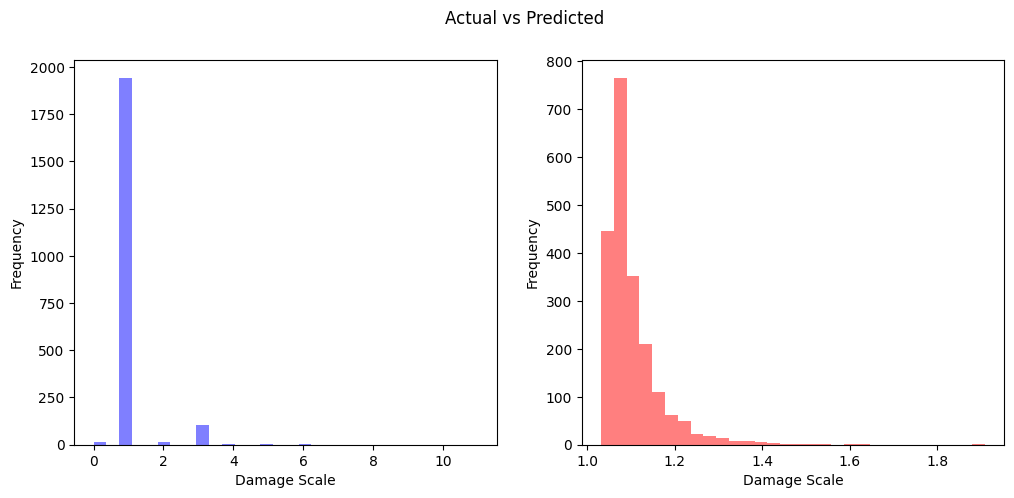

In [12]:
# 모델 예측값과 y 레이블의 정답값 분포 시각화
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 예측값과 실제값의 분포 시각화
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Actual vs Predicted')

# y_test 히스토그램
axs[0].hist(y_test, bins=30, alpha=0.5, color='blue', label='Actual')
axs[0].set_xlabel('Damage Scale')
axs[0].set_ylabel('Frequency')

# y_pred_lgb 히스토그램
axs[1].hist(predictions, bins=30, alpha=0.5, color='red', label='Predicted')
axs[1].set_xlabel('Damage Scale')
axs[1].set_ylabel('Frequency')

plt.show()



In [1]:

fig, ax = plt.subplots()
ax.hist(y_test, bins=30, alpha=0.5, color='blue', label='Actual')
ax.hist(predictions, bins=30, alpha=0.5, color='red', label='Predicted')
ax.set_xlabel('Damage Scale')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()


NameError: name 'plt' is not defined